In [1]:
!pip3 install -r ../requirements.txt

In [3]:
import time
import pickle

import pandas as pd
import chromedriver_binary
from bs4 import BeautifulSoup
from selenium import webdriver

## Logging in and retrieving page source code

In [3]:
WINDOW_SIZE = "1920,1080"

chrome_options = webdriver.chrome.options.Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=%s" % WINDOW_SIZE)
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# specifies the path to the chromedriver.exe
driver = webdriver.Chrome(options=chrome_options)

In [4]:
URL = "https://rezultatai.vrk.lt/"

In [5]:
driver.get(f'{URL}?srcUrl=/rinkimai/1104/1/1746/rezultatai/lt/rezultataiVienm.html')
time.sleep(3)

In [6]:
code = driver.page_source

In [7]:
soup = BeautifulSoup(code, 'html.parser')

In [8]:
our_table = soup.find_all("table", class_="partydata")
# our_table = str(our_table[1]).strip()

In [26]:
number_of_smds = 100 # SMD (single-member district)
sleep_time = 1 # give some time to properly load the page

In [27]:
dfs = {}
for i, each in enumerate(our_table[1].findAll("a")):
    if i >= number_of_smds:
        break
    page = str(each)[9:88]
    driver.get(URL + page)
    time.sleep(sleep_time)
    source_code = driver.page_source
    smd = driver.find_elements_by_tag_name("h3")[1].text
    print(smd)
    dfs[smd] = pd.read_html(str(source_code).strip())[1]

Senamiesčio–Žvėryno (Nr.1) apygarda
Naujamiesčio–Naujininkų (Nr.2) apygarda
Antakalnio (Nr.3) apygarda
Žirmūnų (Nr.4) apygarda
Fabijoniškių (Nr.5) apygarda
Šeškinės–Šnipiškių (Nr.6) apygarda
Justiniškių–Viršuliškių (Nr.7) apygarda
Pilaitės–Karoliniškių (Nr.8) apygarda
Lazdynų (Nr.9) apygarda
Naujosios Vilnios (Nr.10) apygarda
Panerių–Grigiškių (Nr.11) apygarda
Verkių (Nr.12) apygarda
Pašilaičių (Nr.13) apygarda
Šilainių (Nr.14) apygarda
Kalniečių (Nr.15) apygarda
Savanorių (Nr.16) apygarda
Petrašiūnų–Gričiupio (Nr.17) apygarda
Panemunės (Nr.18) apygarda
Aleksoto–Vilijampolės (Nr.19) apygarda
Centro–Žaliakalnio (Nr.20) apygarda
Marių (Nr.21) apygarda
Pajūrio (Nr.22) apygarda
Danės (Nr.23) apygarda
Baltijos (Nr.24) apygarda
Aušros (Nr.25) apygarda
Saulės (Nr.26) apygarda
Panevėžio vakarinė (Nr.27) apygarda
Nevėžio (Nr.28) apygarda
Marijampolės (Nr.29) apygarda
Alytaus (Nr.30) apygarda
Gargždų (Nr.31) apygarda
Šilutės (Nr.32) apygarda
Aukštaitijos (Nr.33) apygarda
Tauragės (Nr.34) apygard

In [37]:
# pickle results from the previous cell to be able to load them next time without a need to scrape
with open('sm_districts.pkl', 'wb') as handle:
    pickle.dump(dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### If you have pickled results from before - start from here

In [11]:
with open('sm_districts.pkl', 'rb') as handle:
    dfs = pickle.load(handle)

In [12]:
def extract_best(df):
    return (
        pd.DataFrame()
        .assign(
            party=df.iloc[:,1],
            percentage=df.iloc[:,6]
        )
        .iloc[:-1]
        .nlargest(2, "percentage")
    )

In [13]:
for district, results in dfs.items():
    dfs[district] = extract_best(results)

In [14]:
agg_results = pd.concat(list(dfs.values())).reset_index(drop=True); agg_results

,party,percentage
0,Tėvynės sąjunga – Lietuvos krikščionys demokratai,2892
1,Lietuvos Respublikos liberalų sąjūdis,2797
2,Tėvynės sąjunga – Lietuvos krikščionys demokratai,3108
3,Laisvės partija,1381
4,Tėvynės sąjunga – Lietuvos krikščionys demokratai,6117
...,...,...
137,Lietuvos Respublikos liberalų sąjūdis,1809
138,Lietuvos valstiečių ir žaliųjų sąjunga,2517
139,Tėvynės sąjunga – Lietuvos krikščionys demokratai,1877
140,Laisvės partija,3490


In [15]:
agg_results["party"] = agg_results["party"].astype('category')

In [25]:
agg_results.party.cat.categories

Index(['Centro partija - tautininkai', 'Darbo partija', 'Išsikėlė pats',
       'Laisvės partija', 'Lietuvos Respublikos liberalų sąjūdis',
       'Lietuvos lenkų rinkimų akcija - Krikščioniškų šeimų sąjunga',
       'Lietuvos socialdemokratų darbo partija',
       'Lietuvos socialdemokratų partija',
       'Lietuvos valstiečių ir žaliųjų sąjunga', 'Lietuvos žaliųjų partija',
       'Nacionalinis susivienijimas', 'Partija „Laisvė ir teisingumas“',
       'Tėvynės sąjunga – Lietuvos krikščionys demokratai'],
      dtype='object')

In [26]:
left_wing_indices = [1, 5, 6, 7, 8]
agg_results.party.cat.categories[left_wing_indices]

In [29]:
right_wing_indices = [3, 4, 12]
agg_results.party.cat.categories[right_wing_indices]

Index(['Laisvės partija', 'Lietuvos Respublikos liberalų sąjūdis',
       'Tėvynės sąjunga – Lietuvos krikščionys demokratai'],
      dtype='object')

In [30]:
agg_results["wing"] = "other"
agg_results.loc[agg_results.party.cat.codes.isin(left_wing_indices), 'wing'] = 'left' 
agg_results.loc[agg_results.party.cat.codes.isin(right_wing_indices), 'wing'] = 'right' 

In [32]:
agg_results

,party,percentage,wing
0,Tėvynės sąjunga – Lietuvos krikščionys demokratai,2892,right
1,Lietuvos Respublikos liberalų sąjūdis,2797,right
2,Tėvynės sąjunga – Lietuvos krikščionys demokratai,3108,right
3,Laisvės partija,1381,right
4,Tėvynės sąjunga – Lietuvos krikščionys demokratai,6117,right
...,...,...,...
137,Lietuvos Respublikos liberalų sąjūdis,1809,right
138,Lietuvos valstiečių ir žaliųjų sąjunga,2517,left
139,Tėvynės sąjunga – Lietuvos krikščionys demokratai,1877,right
140,Laisvės partija,3490,right


In [8]:
count_results = agg_results.groupby("party").size(); count_results.sort_values(ascending=False)

party
Tėvynės sąjunga – Lietuvos krikščionys demokratai              55
Lietuvos valstiečių ir žaliųjų sąjunga                         32
Lietuvos socialdemokratų partija                               13
Laisvės partija                                                12
Lietuvos Respublikos liberalų sąjūdis                           9
Išsikėlė pats                                                   6
Lietuvos socialdemokratų darbo partija                          4
Lietuvos lenkų rinkimų akcija - Krikščioniškų šeimų sąjunga     4
Darbo partija                                                   3
Partija „Laisvė ir teisingumas“                                 1
Nacionalinis susivienijimas                                     1
Lietuvos žaliųjų partija                                        1
Centro partija - tautininkai                                    1
dtype: int64

<AxesSubplot:>

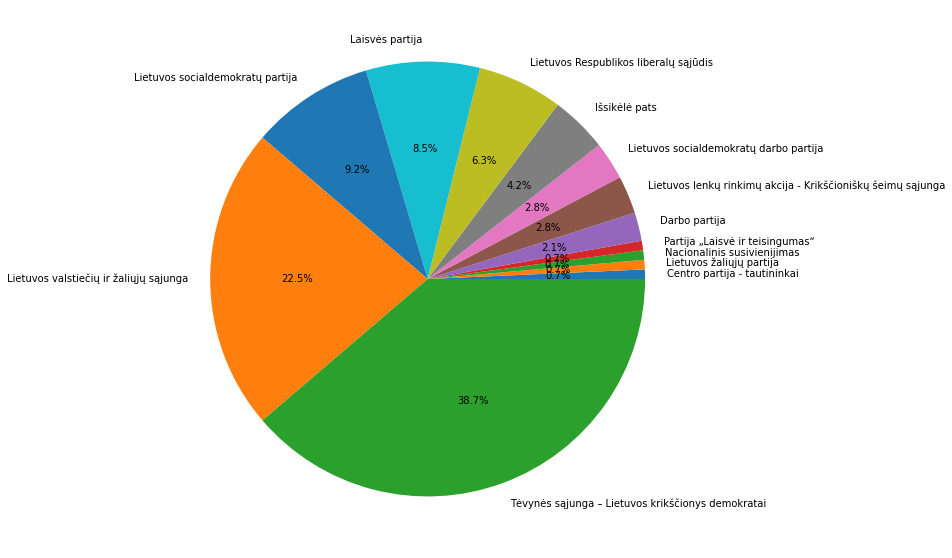

In [9]:
count_results.sort_values().plot.pie(figsize=(10, 10), autopct='%1.1f%%', ylabel="")